# Reproducing results

Since we rebuild SCINet from scratch, it is necessary to test and compare with the original Pytorch implementation to see whether everything functions as expected. To that end, our goal in this notebook is to replicate some of the result posed in the original paper. As such, the goal is not necessary to get as good of a score on the dataset as possible, but rather to get a similar score to the original SCINet.

As alway, we will begin by importing some of the relevant libraries:

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR) #add base to path for relative imports
os.chdir('../..')



Since the loading-preprocessing-training workflow has already been thoroughly discussed before ('exp/training_scinet.ipynb'), we will do it all at once. For the datasets to compare, we will use the 'experiment_ETTh1','experiment_ETTh2' and 'experiment_ETTM1' datasets. The hyperparameters used are similar to those described in the original paper. As training on all datasets can take up to 30 minutes on a CPU, there is also an option to skip this training and instead use pretrained models. To do this, keep 'train' to 'False'. If you instead want to train from scratch, set it to 'True'. Eitherway do run the cell or the rest of the notebook won't run.

In [ ]:
from base.train_scinet import train_scinet
from utils.preprocess_data import preprocess
from utils.data_loading import load_data
from utils.original import orig_param


standardization_settings = {'per_sample': False,
                            'leaky': False,
                            'mode': 'lin', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': [],
                            'total std': []}

datasets = ['ETTh1', 'ETTh2', 'ETTm1']

X_len = 48
Y_len = 24

pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

test_data = {}

for dataset in datasets:

    data, mean_full, std_full = load_data(dataset , pairs)

    proc_results = preprocess(   
                        data = data, 
                        symbols = pairs,
                        data_format = ['price'],
                        fraction = 1,
                        train_frac = .6,
                        val_frac = .2,
                        test_frac = .2,
                        X_LEN = X_len,
                        Y_LEN = Y_len,
                        OVERLAPPING = True,
                        STANDARDIZE = True,
                        standardization_settings = standardization_settings
                        )

    test_data[dataset] = {'X_test': proc_results['X_test'],'y_test': proc_results['y_test']}

    train = False
    if train:

        results = train_scinet( 
                    X_train = proc_results["X_train"],
                    y_train = proc_results["y_train"],
                    X_val = proc_results["X_val"],
                    y_val = proc_results["y_val"],
                    X_test = proc_results["X_test"],
                    y_test = proc_results["y_test"],
                    epochs = orig_param[dataset]['epochs'],
                    batch_size = orig_param[dataset]['batch_size'],
                    X_LEN = X_len,
                    Y_LEN = [Y_len],
                    output_dim = [proc_results["X_train"].shape[2]],
                    selected_columns = None,
                    hid_size= orig_param[dataset]['hid_size'],
                    num_levels= orig_param[dataset]['num_levels'],
                    kernel = orig_param[dataset]['kernel_size'],
                    dropout = orig_param[dataset]['dropout'],
                    loss_weights= [1],
                    learning_rate = orig_param[dataset]['lr_rate'],
                    probabilistic = False)

        results[0].save_weights('exp/reprod/saved_models/model_{}_{}.h5'.format(dataset,orig_param[dataset]['epochs']))
    




Using the test set, we are now in a position to compare our results with those in the original implementation. To that end, we use the saved models to make predictions and plot the errors:

ETTh1
Building model...
ETTh2
Building model...
ETTm1
Building model...


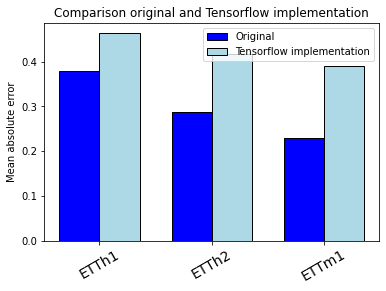

In [3]:
from sklearn.metrics import mean_absolute_error as mae

from base.SCINet import scinet_builder
from utils.original import orig_maes
from utils.plotting import plot_barplot_two


maes = []

datasets = ['ETTh1','ETTh2','ETTm1']

for dataset in datasets:

    print(dataset)

    model = scinet_builder(
                    output_len=  [Y_len],
                    input_len = X_len,
                    output_dim = [proc_results["X_train"].shape[2]],
                    input_dim = proc_results["X_train"].shape[2],
                    selected_columns = None, 
                    loss_weights = [1],
                    hid_size = orig_param[dataset]['hid_size'],
                    num_levels = orig_param[dataset]['num_levels'],
                    kernel = orig_param[dataset]['kernel_size'],
                    dropout = orig_param[dataset]['dropout'],
                    learning_rate = orig_param[dataset]['lr_rate'],)
    model.load_weights('exp/reprod/saved_models/model_{}_10.h5'.format(dataset))
    prediction = model.predict(test_data[dataset]['X_test'])
    maes.append(mae(prediction.flatten(), test_data[dataset]['y_test'].flatten()))

plot_barplot_two(datasets, orig_maes, maes)


Although the result are certainly within the same order of magnitude, there is a clear discrepancy between the two implementations with the original paper reporting significantly better maes. Suprisingly, the reason for this seems to be that the original implementation uses improper preprocessing. That is, in the normalisation the mean and standard deviation are calculated over the entire dataset instead of over $X_train$ only. This way, information leakes from the labels to the samples that are fed to SCINet. To test this, we will enable the 'leaky' setting in our standardization settings. It must be stressed that this is for demonstrational purposes only. THIS IS A BUG NOT A FEATURE!. We the run the same experiment:

In [ ]:
from base.train_scinet import train_scinet
from utils.preprocess_data import preprocess
from utils.data_loading import load_data
from utils.original import orig_param

datasets = ['ETTh1','ETTh2','ETTm1']

X_len = 48
Y_len = 24

pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

test_data_leaky = {}

for dataset in datasets:

    data, mean_full, std_full = load_data(dataset , pairs)

    standardization_settings = {'per_sample': False,
                            'leaky': True,
                            'mode': 'lin', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': mean_full,
                            'total std': std_full}

    proc_results = preprocess(   
                        data = data, 
                        symbols = pairs,
                        data_format = ['price'],
                        fraction = 1,
                        train_frac = .6,
                        val_frac = .2,
                        test_frac = .2,
                        X_LEN = X_len,
                        Y_LEN = Y_len,
                        OVERLAPPING = True,
                        STANDARDIZE = True,
                        standardization_settings = standardization_settings
                        )

    test_data_leaky[dataset] = {'X_test': proc_results['X_test'], 'y_test':proc_results['y_test']}

    train = False
    if train:
        results = train_scinet( 
                    X_train = proc_results["X_train"],
                    y_train = proc_results["y_train"],
                    X_val = proc_results["X_val"],
                    y_val = proc_results["y_val"],
                    X_test = proc_results["X_test"],
                    y_test = proc_results["y_test"],
                    epochs = orig_param[dataset]['epochs'],
                    batch_size = orig_param[dataset]['batch_size'],
                    X_LEN = X_len,
                    Y_LEN = [Y_len],
                    output_dim = [proc_results["X_train"].shape[2]],
                    selected_columns = None,
                    hid_size= orig_param[dataset]['hid_size'],
                    num_levels= orig_param[dataset]['num_levels'],
                    kernel = orig_param[dataset]['kernel_size'],
                    dropout = orig_param[dataset]['dropout'],
                    loss_weights= [1],
                    learning_rate = orig_param[dataset]['lr_rate'],
                    probabilistic = False)

        results[0].save_weights('exp/reprod/saved_models/model_leaky_{}_{}.h5'.format(dataset,orig_param[dataset]['epochs']))

We then make predictioins using the models and compare with both the original and non-leaky implementations.

ETTh1
Building model...
ETTh2
Building model...
ETTm1
Building model...


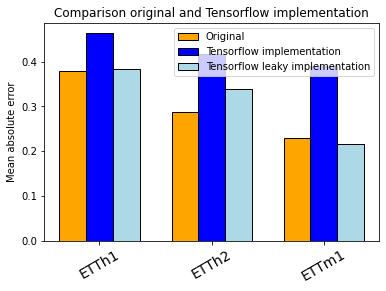

In [11]:
from sklearn.metrics import mean_absolute_error as mae

from base.SCINet import scinet_builder
from utils.original import orig_maes
from utils.plotting import plot_barplot_three

maes_leaky = []

datasets = ['ETTh1','ETTh2','ETTm1']

for dataset in datasets:

    print(dataset)

    model = scinet_builder(
                    output_len=  [Y_len],
                    input_len = X_len,
                    output_dim = [proc_results["X_train"].shape[2]],
                    input_dim = proc_results["X_train"].shape[2],
                    selected_columns = None, 
                    loss_weights = [1],
                    hid_size = orig_param[dataset]['hid_size'],
                    num_levels = orig_param[dataset]['num_levels'],
                    kernel = orig_param[dataset]['kernel_size'],
                    dropout = orig_param[dataset]['dropout'],
                    learning_rate = orig_param[dataset]['lr_rate'],)
    model.load_weights('exp/reprod/saved_models/model_leaky_{}_10.h5'.format(dataset))
    prediction = model.predict(test_data_leaky[dataset]['X_test'])
    maes_leaky.append(mae(prediction.flatten(), test_data_leaky[dataset]['y_test'].flatten()))

plot_barplot_three(datasets, orig_maes, maes, maes_leaky)

We observe that this indeed boosts performance. Although this confirms the working of our implementation this does raise an issue with SCINet. The original authors are have been made aware of this.